# KMEANS Clustering on Amazon Fine Food Reviews Analysis


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import cross_validation
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
from sklearn.exceptions import DataConversionWarning, UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

E:\Users\Admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Reading back the preprocessed data saved in final.sqlite

In [2]:

#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

index      Id   ProductId          UserId                  ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
2  138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
3  138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
4  138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   
2                     1                       1  positive  1191456000   
3                     1                       1  positive  1076025600   
4                     3                       4  positive  1018396800   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   
2               chicken soup with rice months   
3      a good swingy rhythm for reading aloud   
4             A great way to learn the months   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   
2  This is a fun way for children to learn their ...   
3  This is a great little book to read aloud- it ...   
4  This is a book of poetry about the months of t...   

                                         CleanedText  
0  witti littl book make son laugh loud recit car...  
1  grew read sendak book watch realli rosi movi i...  
2  fun way children learn month year learn poem t...  
3  great littl book read nice rhythm well good re...  
4  book poetri month year goe month cute littl po...

In [3]:
my_final = df[:60000]
print(my_final.shape)

(60000, 12)


In [4]:
X = my_final['CleanedText']

In [36]:

def print_wordcloud(cluster):

    review=" ".join(cluster)
    wordcloud = WordCloud(width=800,height=800,background_color="white",
                      stopwords = set(STOPWORDS)).generate(review)

# Display the generated image:
    plt.figure(figsize = (8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Bag of Words (BoW)

In [5]:
count_vec = CountVectorizer(max_features=2000)
X_bow = count_vec.fit_transform(X)
print(X_bow.shape)

(60000, 2000)


## Kmeans Alogorithm

In [8]:
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(X_bow)
    loss.append(kmeans.inertia_)

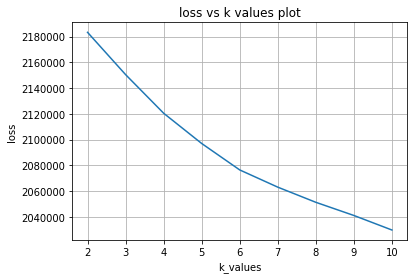

In [11]:
plt.plot(k_values,loss)
plt.xlabel('k_values')
plt.ylabel('loss')
plt.title('loss vs k values plot')
plt.grid()
plt.show()

### OBSERVATION: 
 In the above plot at K=6, we see some inflection and stepness of the curve starts to reduce slowly, that is why, we will take k=6

In [6]:
kmeans = KMeans(n_clusters=6, n_jobs=-1).fit(X_bow)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Manually Creating clusters

In [15]:
reviews = df['CleanedText'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])
    else :
        cluster6.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))

No. of reviews in Cluster-1 :  4261

No. of reviews in Cluster-2 :  7166

No. of reviews in Cluster-3 :  734

No. of reviews in Cluster-4 :  553

No. of reviews in Cluster-5 :  2246

No. of reviews in Cluster-6 :  45040


### Reading the reviews in each cluster

Review-1 : 
 soon take sip two feel sort wash open lung definit caus one breath easi hot tea add tea bag two ice tea bag healthi stuff

Review-2 : 
 pulmonari condit tea great tea lover use success enjoy

Review-3 : 
 husband asthma use pevent inhal along inhal attack occur attack sever bathroom turn shower hot inhal steam even attack continu prepar breath easi herbal tea within minut drink tea asthma settl alway carri tea bag never leav hous anywher without tea life saver even asthma tea also help breath better respiratori infect recent flu sever week much cough tea awesom must breath ailment



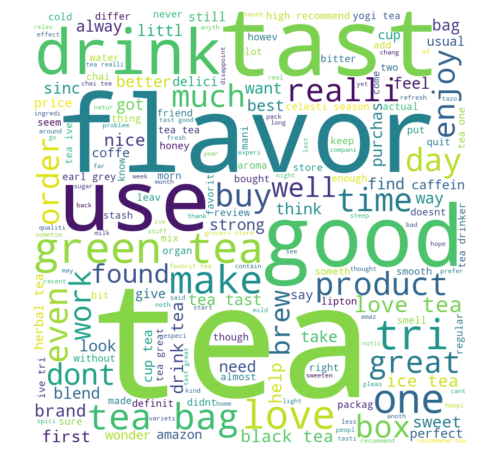

In [37]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1
print_wordcloud(cluster1)

Review-1 : 
 great littl book read nice rhythm well good repetit littl one like line chicken soup rice child get month year wonder place like bombay nile eat well know get eat kid mauric sendak version ice skate treat rose head long time wont even know came surpris came littl witti book

Review-2 : 
 day person say chicken soup theyr probabl go follow word soul mayb teenag soul didnt use way rememb time person said chicken soup word follow enthusiast rice power mauric sendak catchi children book pleas report care read book today find hasnt dimish jot term frolicksom fun book led whirlwind chicken soup year host boy bear littl resembl sendak great rhyme tale pierr look demeanor catchi flounci bounci combo soup peopl love ostens book meant teach children differ month year month get rhythmic poem accompani illustr fair simpl pen ink draw occasion splash blue vari shade yellow gray green may wonder author could ever hope come twelv high origin poem mean honest much say even fanciest soup l

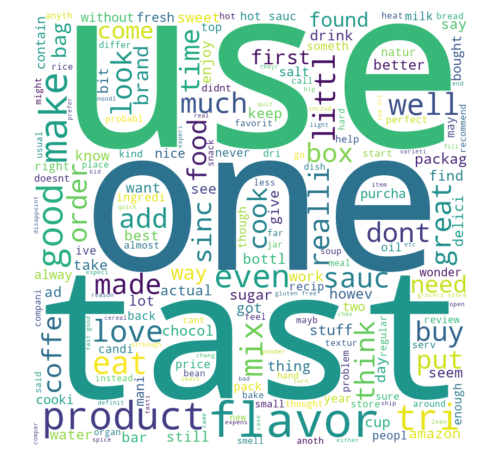

In [38]:
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1
print_wordcloud(cluster2)

Review-1 : 
 hallelujah wick mole dead year hunt critter read entir internet year research led mole problem let save time forget everyth think know way deal mole kill way kill trap bait dont work treat grub dont work mole primarili feed worm grub sonic vibrat thingi dont work trap work dont follow direct packag best explain employ product first stamp mole run yard ordinarili dont want encourag mole dig new run thus damag need current pictur mole activ yard next day stamp run observ new run look long straight run long straight run like mole highway curvi short run hunt road curvi run less travel hunt highway open trap set safeti catch set trap next run want place take foot stamp mole run want place trap foot width dont push hard want ground stamp level rest yard take straight blade shovel creat notch either side trap blade dont real deep coupl inch wiggl shovel creat pocket blade trap care place trap notch pocket creat trigger trap level ground unhook safeti took day catch mole set trap

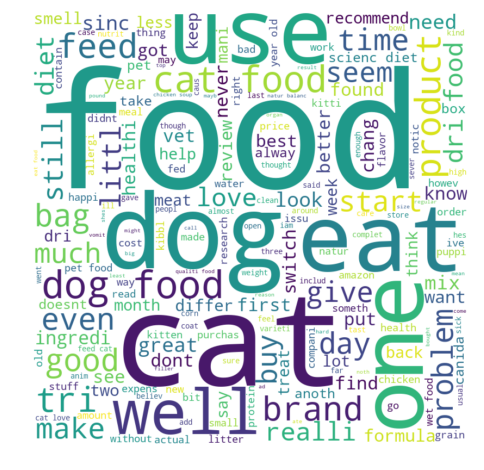

In [39]:

# Three Reviews of cluster 3
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1
print_wordcloud(cluster3)

Review-1 : 
 absolut amaz peopl spend two dollar singl cup coffe yet still buy low cost tea bag groceri store claim like coffe better mani peopl tast real good cup tea good tea come count per cardboard box tea higher qualiti shouldnt cheap cardboard box seal tin pack airtight bag order preserv flavor leav special select cheapest tea bought bulk lowest qualiti tea part tea leaf yes cost matter tea like coffe unless your realli lazi admit tea also never ever serv bag tea loos form confin bag tea leav need expand water releas full flavor buy loos tea leav buy amazon high end groceri store special market cost plus tea shopp unless want brew whole pot tea leav plot mani way make tea right one person mug solv singl serv dilemma big sturdi made glass import thing though come infus look like cylindr filter place mug spoon bit tea filter dunk mug tea brew right result best tea youll ever drank brew realli easi add tea filter add sub boil hot water wait remov infus drink need add sugar cream wel

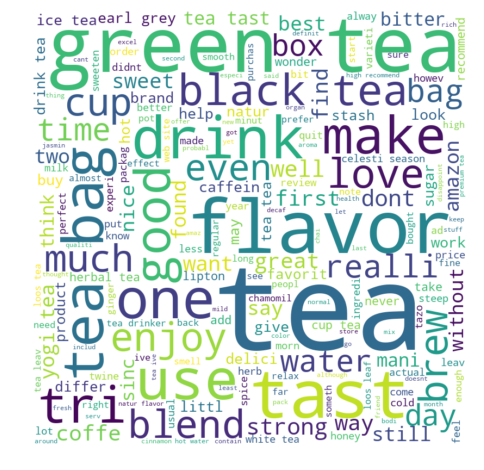

In [40]:

# Three Reviews of cluster 4
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1
print_wordcloud(cluster4)

Review-1 : 
 feed greyhound treat year hound littl finicki love treat expens relat biscuit find good addit diet treat easi teeth sinc protein treat care overindulg pet regular basi great treat take walk stuff pocket easili found price vari vendor vendor shop around

Review-2 : 
 one product welsh terrier eat sophi food alergi care feed dog oscar also get treat love food alergi product simpl ingredi addit dog need

Review-3 : 
 dog treat lhasa apso eat make happ becuas ad ingredi preserv well ad salt dog treat vet approv



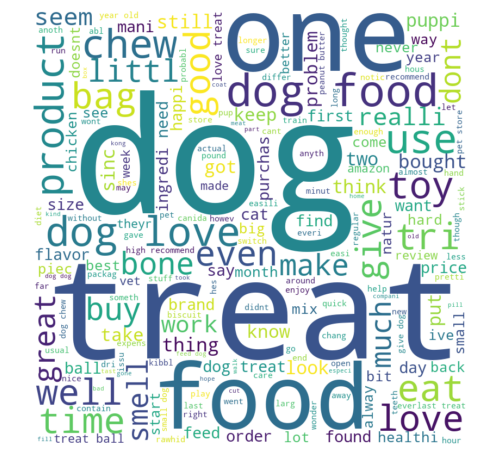

In [41]:

# Three Reviews of cluster 5
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster5[i]))
    count +=1
print_wordcloud(cluster5)

Review-1 : 
 witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg

Review-2 : 
 grew read sendak book watch realli rosi movi incorpor love son love howev miss hard cover version paperback seem kind flimsi take two hand keep page open

Review-3 : 
 fun way children learn month year learn poem throughout school year like handmot invent poem



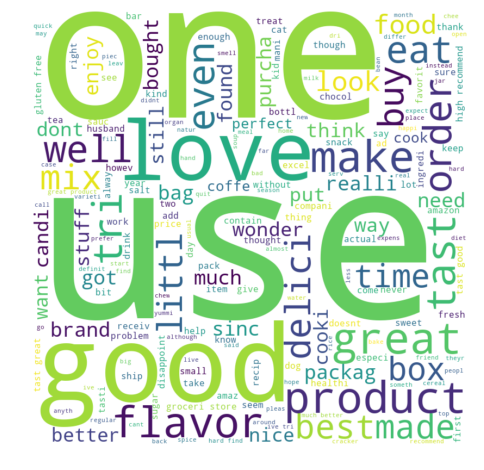

In [42]:

# Three Reviews of cluster 6
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster6[i]))
    count +=1
print_wordcloud(cluster6)

### Visualizing Clusters

centroids
[[-0.61792109  0.3068277 ]
 [ 0.5194639  -1.3327037 ]
 [ 7.36564699  2.97602489]
 [ 3.12105435 -5.50412732]
 [ 2.05007407  1.56987832]
 [19.60761764  7.09611362]]
labels
[0 0 0 ... 0 1 0]


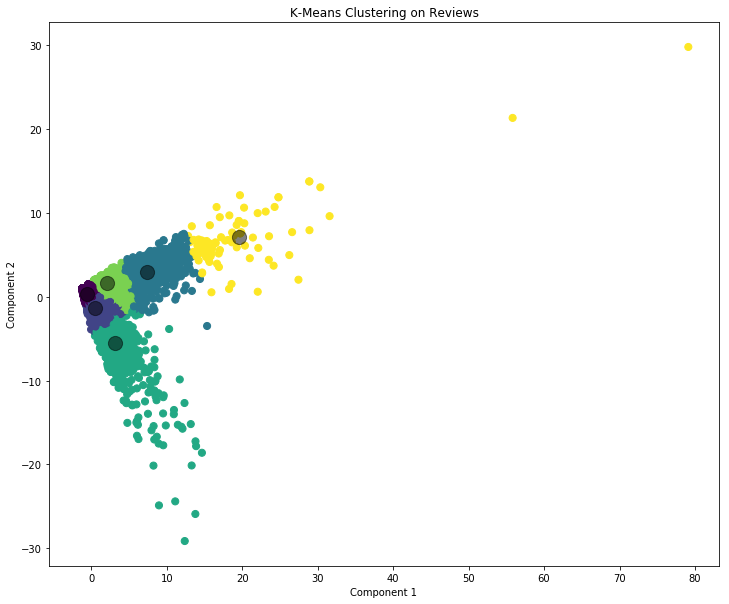

In [32]:
X_den =X_bow.todense()
Xr= PCA(n_components=2).fit_transform(X_den)
kmeans.fit(Xr)
y_kmeans = kmeans.predict(Xr)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print("centroids")
print(centroids)
print("labels")
print(labels)

plt.figure(figsize = (12,10))
plt.scatter(Xr[:, 0], Xr[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("K-Means Clustering on Reviews")
plt.show()

# TF-IDF

In [43]:
tfidf = TfidfVectorizer(max_features=2000) #Using bi-grams
X_tfidf = tfidf.fit_transform(X)
print("Train Data Size: ",X_tfidf.shape)


Train Data Size:  (60000, 2000)


## Kmeans Alogorithm

In [8]:
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans1 = KMeans(n_clusters=i, n_jobs=-1).fit(X_tfidf)
    loss.append(kmeans1.inertia_)

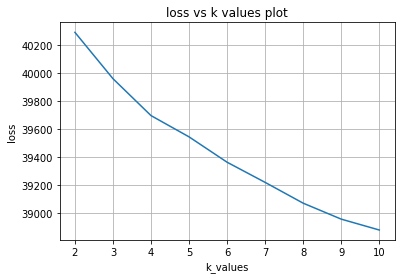

In [9]:
plt.plot(k_values,loss)
plt.xlabel('k_values')
plt.ylabel('loss')
plt.title('loss vs k values plot')
plt.grid()
plt.show()

### OBSERVATION: 
 In the above plot at K=7, we see some inflection and stepness of the curve starts to reduce slowly, that is why, we will take k=7

In [44]:
kmeans = KMeans(n_clusters=7, n_jobs=-1).fit(X_tfidf)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Manually Creating clusters

In [46]:
reviews = df['CleanedText'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])
    elif kmeans.labels_[i] == 5:
        cluster6.append(reviews[i])
    else :
        cluster7.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-6 : ",len(cluster7))

No. of reviews in Cluster-1 :  13578

No. of reviews in Cluster-2 :  30191

No. of reviews in Cluster-3 :  2212

No. of reviews in Cluster-4 :  4324

No. of reviews in Cluster-5 :  5787

No. of reviews in Cluster-6 :  1827

No. of reviews in Cluster-6 :  2081


### Reading the reviews in each cluster

Review-1 : 
 book famili favorit read children small order new famili enjoy

Review-2 : 
 great book perfect condit arriv short amount time long expect deliveri date

Review-3 : 
 book purchas birthday gift year old boy squeal delight hug told keep return librari



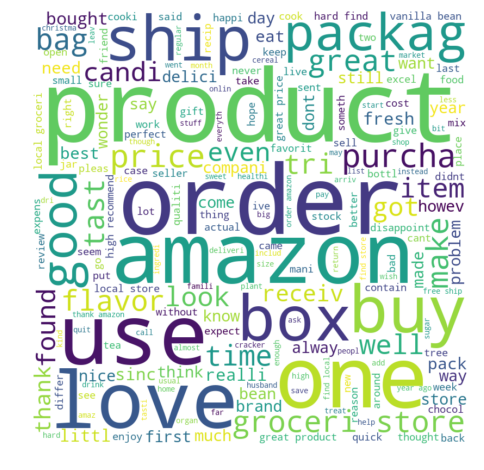

In [47]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1
print_wordcloud(cluster1)

Review-1 : 
 witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg

Review-2 : 
 grew read sendak book watch realli rosi movi incorpor love son love howev miss hard cover version paperback seem kind flimsi take two hand keep page open

Review-3 : 
 fun way children learn month year learn poem throughout school year like handmot invent poem



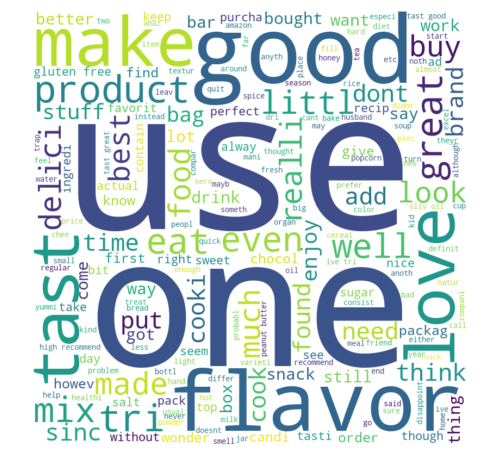

In [48]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1
print_wordcloud(cluster2)

Review-1 : 
 stay away order compani receiv order time amaz coffe pod stamp date month past due

Review-2 : 
 arabica espression espresso excel espresso drink tradit espresso unlik good drip coffe made mix arabica robusta coffe tast differ notic dont strong favorit use pod conveni although also roast green bean espresso well look negat review theyr most best date pass would also upset spend money get expir pod point pod good quit time nomin expir date found hand espression classic pod late date made accept though spectacular espresso basic theyr vacuum pack much happen insid wrapper

Review-3 : 
 base upon various review decid give tri normal use starbuck espresso pod say tast espression much bland coffe tast weaker



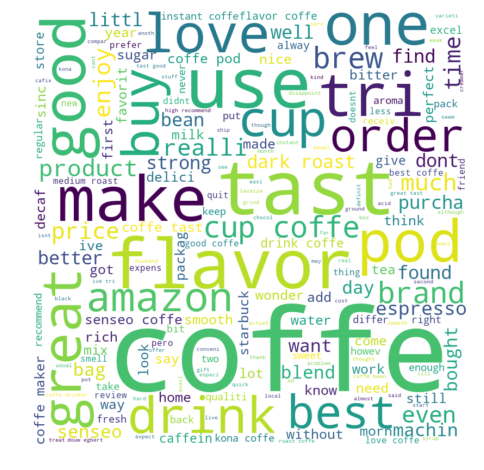

In [49]:
# Three Reviews of cluster 3
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1
print_wordcloud(cluster3)

Review-1 : 
 dog love saw pet store tag attach regard made china satisfi safe

Review-2 : 
 feed greyhound treat year hound littl finicki love treat expens relat biscuit find good addit diet treat easi teeth sinc protein treat care overindulg pet regular basi great treat take walk stuff pocket easili found price vari vendor vendor shop around

Review-3 : 
 one product welsh terrier eat sophi food alergi care feed dog oscar also get treat love food alergi product simpl ingredi addit dog need



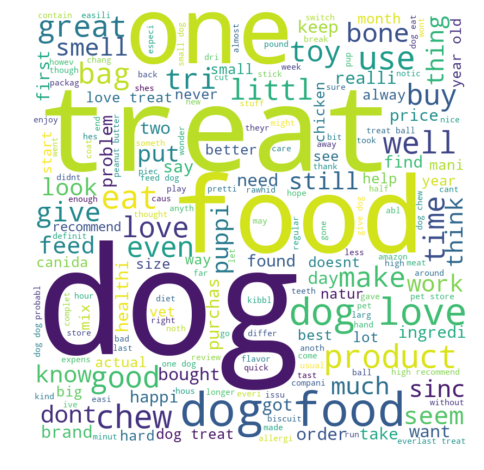

In [50]:
# Three Reviews of cluster 4
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1
print_wordcloud(cluster4)

Review-1 : 
 soon take sip two feel sort wash open lung definit caus one breath easi hot tea add tea bag two ice tea bag healthi stuff

Review-2 : 
 pulmonari condit tea great tea lover use success enjoy

Review-3 : 
 husband asthma use pevent inhal along inhal attack occur attack sever bathroom turn shower hot inhal steam even attack continu prepar breath easi herbal tea within minut drink tea asthma settl alway carri tea bag never leav hous anywher without tea life saver even asthma tea also help breath better respiratori infect recent flu sever week much cough tea awesom must breath ailment



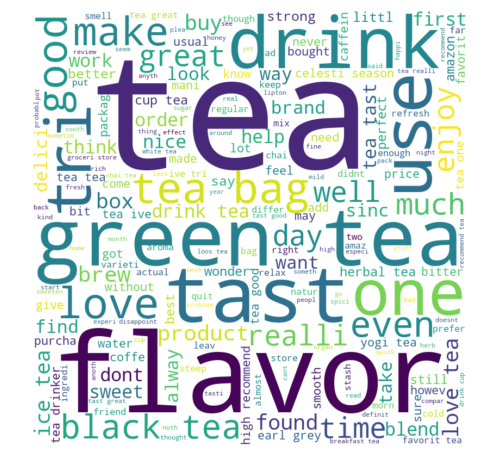

In [51]:
# Three Reviews of cluster 5
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster5[i]))
    count +=1
print_wordcloud(cluster5)

Review-1 : 
 month old lab goe nut liver treat vet recommend healthi treat pup act like cat catnip big hit price size excel last good

Review-2 : 
 key treat cat flea trap help alert get hand help get back ontrol quick atrract flea captur

Review-3 : 
 take care five cat give flea treatment everi month none cat flea theyr insid cat notic floor bathroom flea purchas trap within hour put cover flea even though flea anywher els hous also place trap realli give peac mind want cat comfort healthi ill alway put trap flea ever discov ill know job



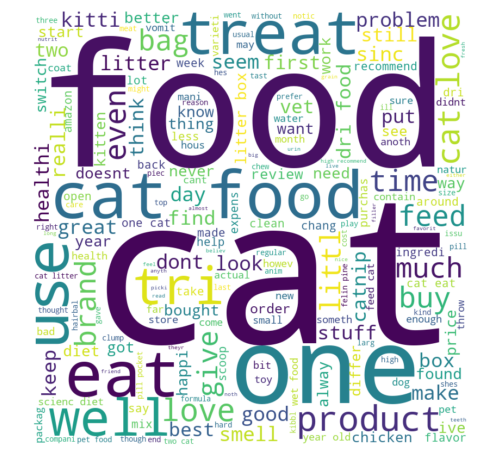

In [52]:
# Three Reviews of cluster 6
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster6[i]))
    count +=1
print_wordcloud(cluster6)

Review-1 : 
 love hot pepper hot sauc ground chili pepper grow pepper roast grind also like collect use wide varieti product one sinc chef prudhomm one first first bring cajun food mainstream fine dine scene felt confid tri ground chili assort bear name like would recommend someon interest spicier food one thing bear mind spici necessarili mean hot chili mild medium matter fact jar heat level rate pepper break like anaheim california beauti heat level new mexico perfecto heat level guajillo heat level ancho heat level pasilla heat level chipotl heat level arbol heat level person think chipotl arbol milder list that opinion bottl contain ounc fair amount peopl bear mind ground chili best consum within month purchas known peopl keep jar ground chili pantri year far best replac bottl sold separ honest buy ground chili bulk refil bottl real nice starter set

Review-2 : 
 great product like touch hot pasta first purchas year ago myrtl beach hard find live husband eat pasta withot also put s

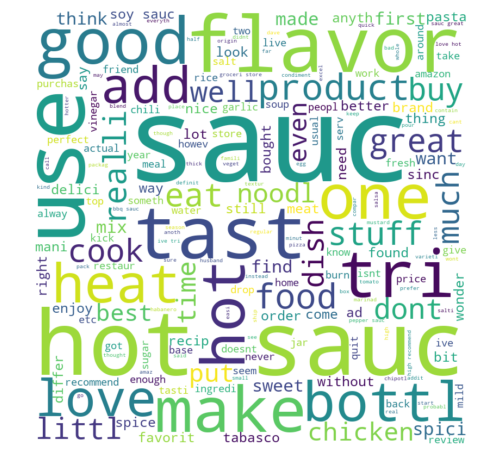

In [53]:
# Three Reviews of cluster 7
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster7[i]))
    count +=1
print_wordcloud(cluster7)

### Visualizing Clusters

centroids
[[-0.07250359  0.14473728]
 [-0.0246597  -0.06597618]
 [ 0.48169341  0.07698771]
 [ 0.16018217  0.00938079]
 [-0.11069409  0.31969094]
 [ 0.31386772  0.04116633]
 [-0.03693491 -0.00838338]]
labels
[6 6 6 ... 6 1 1]


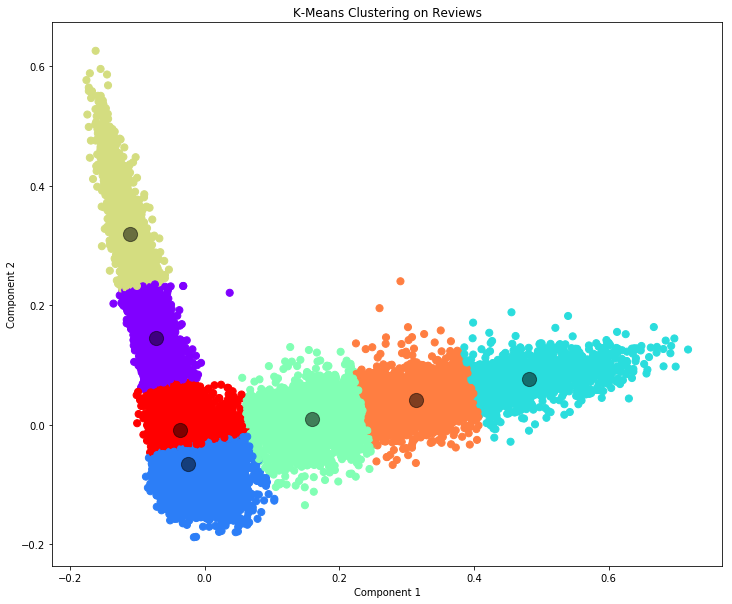

In [38]:

X_den =X_tfidf.todense()
Xr= PCA(n_components=2).fit_transform(X_den)
kmeans.fit(Xr)
y_kmeans = kmeans.predict(Xr)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print("centroids")
print(centroids)
print("labels")
print(labels)

plt.figure(figsize = (12,10))
plt.scatter(Xr[:, 0], Xr[:, 1], c=y_kmeans, s=50, cmap='rainbow')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("K-Means Clustering on Reviews")
plt.show()


# Word TO Vec

In [54]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [55]:
# Train your own Word2Vec model using your own train corpus
import gensim
list_of_sent = []
for sent in X:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

E:\Users\Admin\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [56]:
# min_count = 5 considers only words that occured atleast 5 times

from gensim.models import Word2Vec
w2v_model=Word2Vec(list_of_sent,min_count=5,size=300, workers=4)
w2v_words = list(w2v_model.wv.vocab)

# Avg W2V, TFIDF-W2V

In [57]:
from tqdm import tqdm
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


100%|██████████████████████████████████| 60000/60000 [00:20<00:00, 2887.27it/s]


60000
300


In [58]:
X_w2v = np.array(sent_vectors)
X_w2v=np.nan_to_num(X_w2v)


## Kmeans Alogorithm

In [15]:
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans1 = KMeans(n_clusters=i, n_jobs=-1).fit(X_w2v)
    loss.append(kmeans1.inertia_)

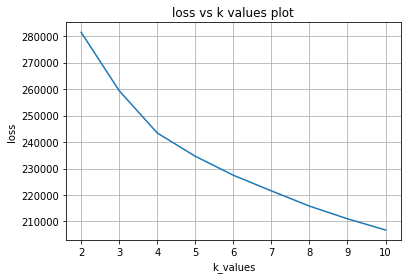

In [16]:
plt.plot(k_values,loss)
plt.xlabel('k_values')
plt.ylabel('loss')
plt.title('loss vs k values plot')
plt.grid()
plt.show()

### OBSERVATION: 
 In the above plot at K=6, we see some inflection and stepness of the curve starts to reduce slowly, that is why, we will take k=6

In [45]:
kmeans = KMeans(n_clusters=6, n_jobs=-1).fit(X_w2v)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Manually Creating clusters

In [60]:
reviews = df['CleanedText'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])
    else :
        cluster6.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-5 : ",len(cluster6))


No. of reviews in Cluster-1 :  13578

No. of reviews in Cluster-2 :  30191

No. of reviews in Cluster-3 :  2212

No. of reviews in Cluster-4 :  4324

No. of reviews in Cluster-5 :  5787

No. of reviews in Cluster-5 :  3908


### Reading the reviews in each cluster

Review-1 : 
 book famili favorit read children small order new famili enjoy

Review-2 : 
 great book perfect condit arriv short amount time long expect deliveri date

Review-3 : 
 book purchas birthday gift year old boy squeal delight hug told keep return librari



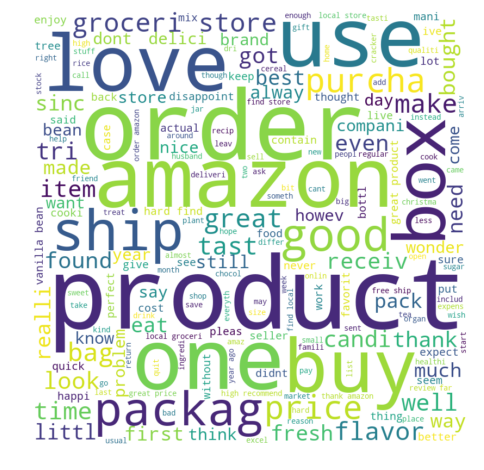

In [61]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1
print_wordcloud(cluster1)

Review-1 : 
 witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg

Review-2 : 
 grew read sendak book watch realli rosi movi incorpor love son love howev miss hard cover version paperback seem kind flimsi take two hand keep page open

Review-3 : 
 fun way children learn month year learn poem throughout school year like handmot invent poem



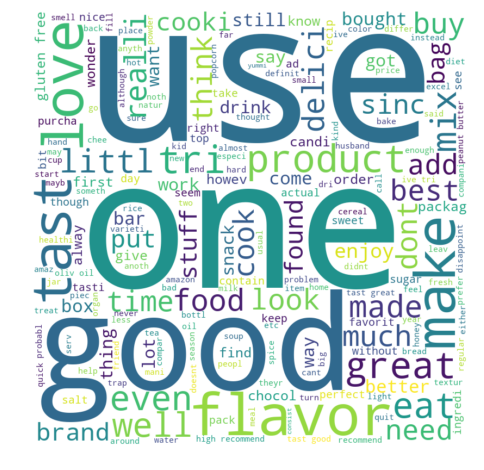

In [62]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1
print_wordcloud(cluster2)

Review-1 : 
 stay away order compani receiv order time amaz coffe pod stamp date month past due

Review-2 : 
 arabica espression espresso excel espresso drink tradit espresso unlik good drip coffe made mix arabica robusta coffe tast differ notic dont strong favorit use pod conveni although also roast green bean espresso well look negat review theyr most best date pass would also upset spend money get expir pod point pod good quit time nomin expir date found hand espression classic pod late date made accept though spectacular espresso basic theyr vacuum pack much happen insid wrapper

Review-3 : 
 base upon various review decid give tri normal use starbuck espresso pod say tast espression much bland coffe tast weaker



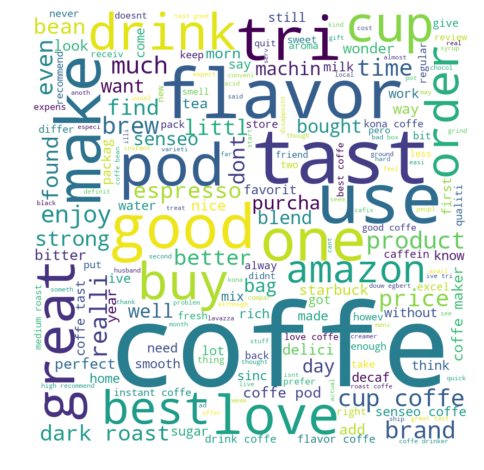

In [63]:
# Three Reviews of cluster 3
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1
print_wordcloud(cluster3)

Review-1 : 
 dog love saw pet store tag attach regard made china satisfi safe

Review-2 : 
 feed greyhound treat year hound littl finicki love treat expens relat biscuit find good addit diet treat easi teeth sinc protein treat care overindulg pet regular basi great treat take walk stuff pocket easili found price vari vendor vendor shop around

Review-3 : 
 one product welsh terrier eat sophi food alergi care feed dog oscar also get treat love food alergi product simpl ingredi addit dog need



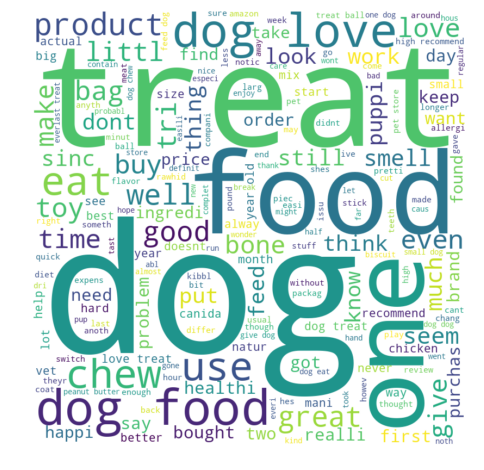

In [64]:
# Three Reviews of cluster 4
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1
print_wordcloud(cluster4)

Review-1 : 
 soon take sip two feel sort wash open lung definit caus one breath easi hot tea add tea bag two ice tea bag healthi stuff

Review-2 : 
 pulmonari condit tea great tea lover use success enjoy

Review-3 : 
 husband asthma use pevent inhal along inhal attack occur attack sever bathroom turn shower hot inhal steam even attack continu prepar breath easi herbal tea within minut drink tea asthma settl alway carri tea bag never leav hous anywher without tea life saver even asthma tea also help breath better respiratori infect recent flu sever week much cough tea awesom must breath ailment



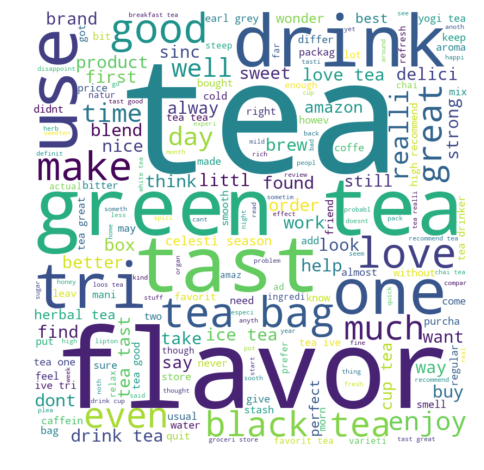

In [65]:
# Three Reviews of cluster 5
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster5[i]))
    count +=1
print_wordcloud(cluster5)

Review-1 : 
 month old lab goe nut liver treat vet recommend healthi treat pup act like cat catnip big hit price size excel last good

Review-2 : 
 key treat cat flea trap help alert get hand help get back ontrol quick atrract flea captur

Review-3 : 
 take care five cat give flea treatment everi month none cat flea theyr insid cat notic floor bathroom flea purchas trap within hour put cover flea even though flea anywher els hous also place trap realli give peac mind want cat comfort healthi ill alway put trap flea ever discov ill know job



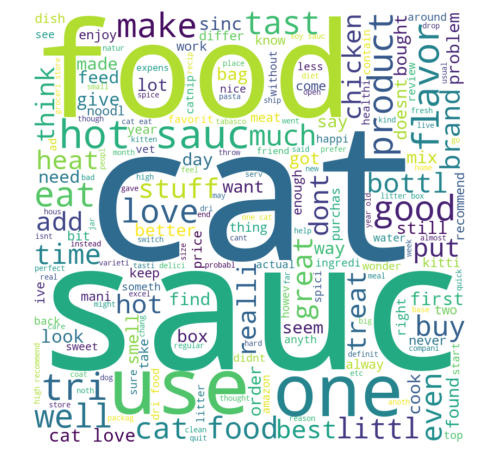

In [66]:
# Three Reviews of cluster 6
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster6[i]))
    count +=1
print_wordcloud(cluster6)

### Visualizing Clusters

centroids:
[[-0.06961865 -0.01576946]
 [-1.44407675  0.80133122]
 [-1.07253782 -0.98994888]
 [ 1.09557204 -0.75789828]
 [ 1.20185533  1.49858193]]


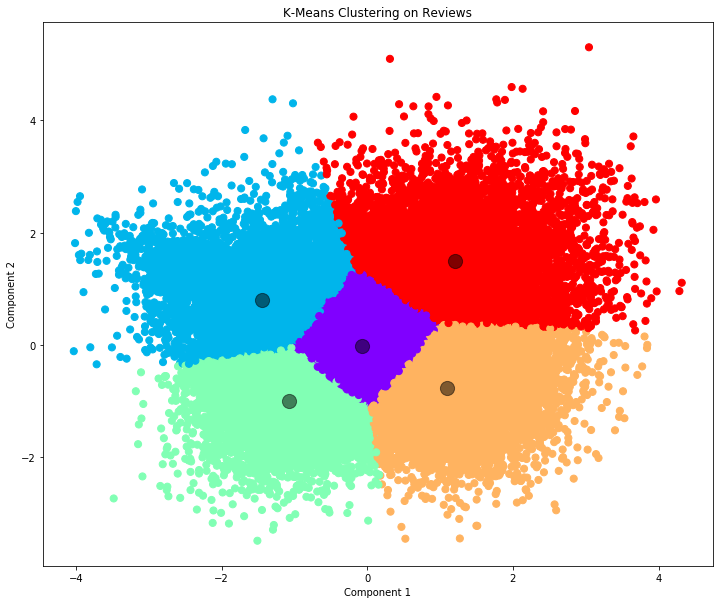

In [53]:
from sklearn.decomposition import PCA
#X_trainden =X_trainw2v.todense()
Xr= PCA(n_components=2).fit_transform(X_w2v)
kmeans.fit(Xr)
y_kmeans = kmeans.predict(Xr)

centroids = kmeans.cluster_centers_

print("centroids:")
print(centroids)

plt.figure(figsize = (12,10))
plt.scatter(Xr[:, 0], Xr[:, 1], c=y_kmeans, s=50, cmap='rainbow')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("K-Means Clustering on Reviews")
plt.show()

## TF-IDF weighted Word2Vec

In [67]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [68]:
from tqdm import tqdm
# TF-IDF weighted Word2Vec
#dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            if word in w2v_words:
                vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 60000/60000 [02:10<00:00, 461.28it/s]


In [69]:

X_w2vtfidf=np.array(tfidf_sent_vectors)

In [70]:
X_w2vtfidf.shape


(60000, 300)

In [71]:
X_w2vtfidf=np.nan_to_num(X_w2vtfidf)

## Kmeans Alogorithm

In [32]:
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans1 = KMeans(n_clusters=i, n_jobs=-1).fit(X_w2vtfidf)
    loss.append(kmeans1.inertia_)

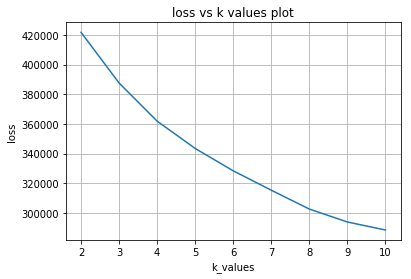

In [33]:
plt.plot(k_values,loss)
plt.xlabel('k_values')
plt.ylabel('loss')
plt.title('loss vs k values plot')
plt.grid()
plt.show()

### OBSERVATION: 
 In the above plot at K=6, we see some inflection and stepness of the curve starts to reduce slowly, that is why, we will take k=6

In [72]:
kmeans = KMeans(n_clusters=6, n_jobs=-1).fit(X_w2vtfidf)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Manually Creating clusters

In [73]:
reviews = df['CleanedText'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i]) 
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i]) 
    else :
        cluster6.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))

No. of reviews in Cluster-1 :  6196

No. of reviews in Cluster-2 :  12624

No. of reviews in Cluster-3 :  14741

No. of reviews in Cluster-4 :  6196

No. of reviews in Cluster-5 :  10236

No. of reviews in Cluster-6 :  10007


### Reading the reviews in each cluster

Review-1 : 
 dog love saw pet store tag attach regard made china satisfi safe

Review-2 : 
 feed greyhound treat year hound littl finicki love treat expens relat biscuit find good addit diet treat easi teeth sinc protein treat care overindulg pet regular basi great treat take walk stuff pocket easili found price vari vendor vendor shop around

Review-3 : 
 one product welsh terrier eat sophi food alergi care feed dog oscar also get treat love food alergi product simpl ingredi addit dog need



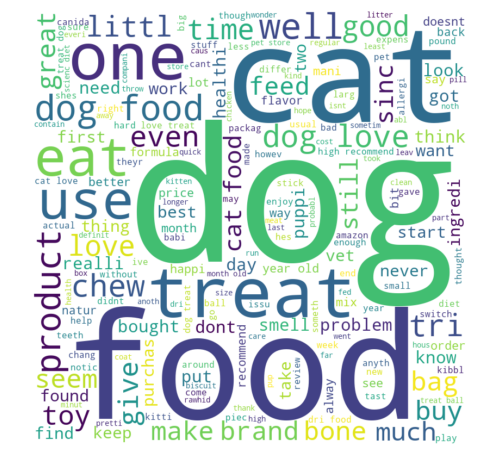

In [74]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1
print_wordcloud(cluster1)

Review-1 : 
 product archer farm best drink mix ever mix flavor packet water bottl contain natur sweetner stevia real fruit flavor food color color fruit veget color pure natur tast great eight packet box contain calori per packet thank archer farm

Review-2 : 
 book easi read ingredi avail store unlik recip book special store find ingredi use make food son thing wish recip like great one like healthi yummi snack

Review-3 : 
 yes bit expens high qualiti pure nutrit good train treat high calori high recommend



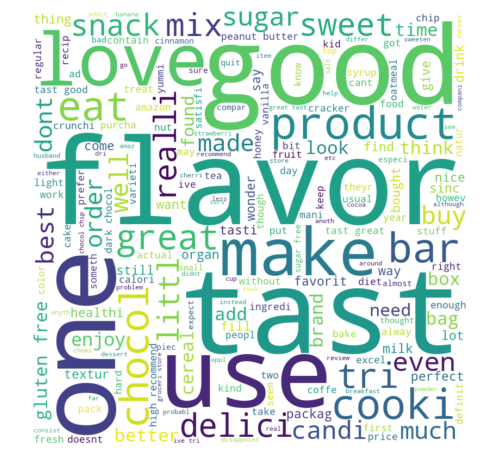

In [75]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1
print_wordcloud(cluster2)

Review-1 : 
 witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg

Review-2 : 
 grew read sendak book watch realli rosi movi incorpor love son love howev miss hard cover version paperback seem kind flimsi take two hand keep page open

Review-3 : 
 fun way children learn month year learn poem throughout school year like handmot invent poem



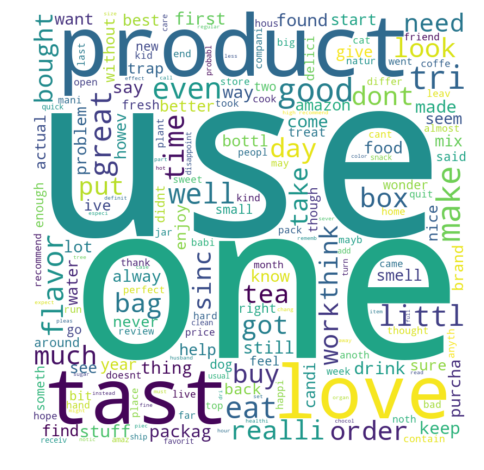

In [76]:
# Three Reviews of cluster 3
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1
print_wordcloud(cluster3)

Review-1 : 
 soon take sip two feel sort wash open lung definit caus one breath easi hot tea add tea bag two ice tea bag healthi stuff

Review-2 : 
 pulmonari condit tea great tea lover use success enjoy

Review-3 : 
 husband asthma use pevent inhal along inhal attack occur attack sever bathroom turn shower hot inhal steam even attack continu prepar breath easi herbal tea within minut drink tea asthma settl alway carri tea bag never leav hous anywher without tea life saver even asthma tea also help breath better respiratori infect recent flu sever week much cough tea awesom must breath ailment



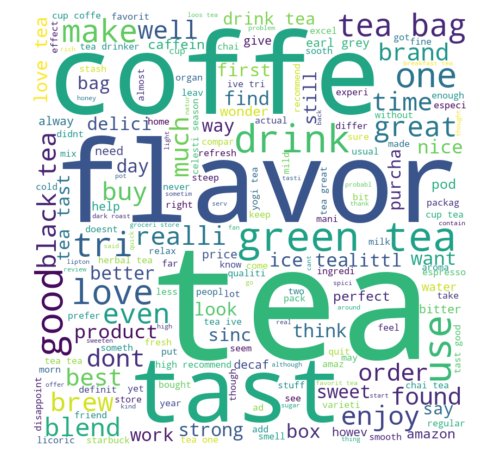

In [77]:
# Three Reviews of cluster 4
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1
print_wordcloud(cluster4)

Review-1 : 
 ive alway love chicken soup rice late ethel alway made homemad chicken chicken soup rice book take back day mother father sister went ethel hous late isador would cook chicken ethel blind remind time togeth famili bring back happi memori love share bowl hot soup

Review-2 : 
 june saw charm group rose begin droop pep chicken soup sprinkl sprinkl twice sprinkl chicken soup rice great book teach children month year repetit phrase funni littl stori accompani pictur make ideal bedtim read isnt near good sendak book like wild thing boy didnt care still carri uniqu brand charm

Review-3 : 
 day person say chicken soup theyr probabl go follow word soul mayb teenag soul didnt use way rememb time person said chicken soup word follow enthusiast rice power mauric sendak catchi children book pleas report care read book today find hasnt dimish jot term frolicksom fun book led whirlwind chicken soup year host boy bear littl resembl sendak great rhyme tale pierr look demeanor catchi flou

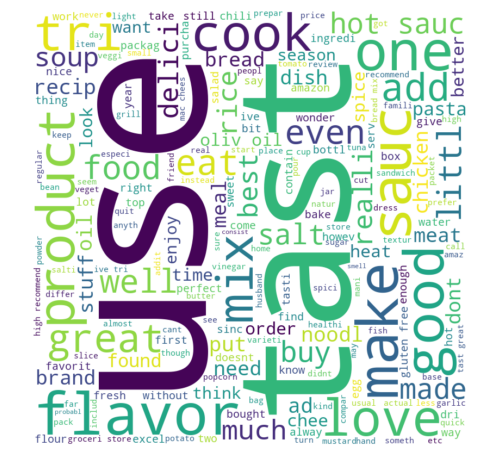

In [78]:
# Three Reviews of cluster 5
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster5[i]))
    count +=1
print_wordcloud(cluster5)

Review-1 : 
 great book perfect condit arriv short amount time long expect deliveri date

Review-2 : 
 book purchas birthday gift year old boy squeal delight hug told keep return librari

Review-3 : 
 one best children book ever written mini version book portray one price product sent email regard bewilder amazon got respons



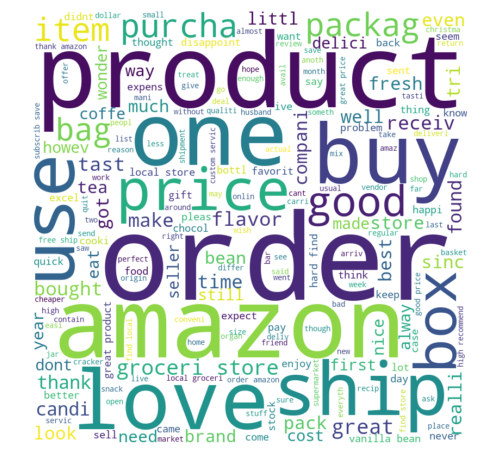

In [79]:
# Three Reviews of cluster 6
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster6[i]))
    count +=1
print_wordcloud(cluster6)

### Visualizing Clusters

centroids:
[[-0.34174726 -0.97484742]
 [ 3.75339775 -1.39120046]
 [-0.1690765   1.97908088]
 [-1.91743292 -1.36939591]
 [-0.34139318  0.47186939]
 [ 1.56724541  0.2045298 ]]


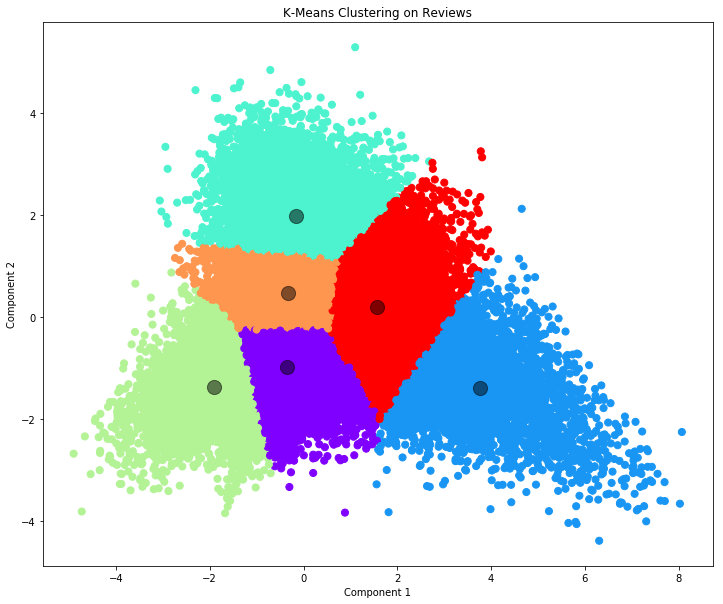

In [26]:
from sklearn.decomposition import PCA
#X_trainden =X_trainw2v.todense()
Xr= PCA(n_components=2).fit_transform(X_w2vtfidf)
kmeans.fit(Xr)
y_kmeans = kmeans.predict(Xr)

centroids = kmeans.cluster_centers_

print("centroids:")
print(centroids)

plt.figure(figsize = (12,10))
plt.scatter(Xr[:, 0], Xr[:, 1], c=y_kmeans, s=50, cmap='rainbow')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("K-Means Clustering on Reviews")
plt.show()